In [11]:
%load_ext autoreload
%autoreload 2

from models import Encoder, Decoder
import torch
import torch.nn as nn
from utils import *
from PIL import Image
from nltk.translate import bleu_score
from beam_search import BeamSearch

# Evaluate the models

In this notebook we run identical cells for each model we have tested. Models are shown below. Some of the hyper parameters are listed to give the reader a quick view of what was changing.

All models had training and validation data sampled randomly form the MS Coco train2017 file (which contain ~128k images). The test data was sampled from the MS Coco val2017 file. 

* Models named `random`, just sampled images and associated captions randomly from the data.
* Models named `sports` reduced the scope of data to only pictures including objects within the sports super-category in MS Coco. This reduced the size of the train2017 data from ~128k to ~23k images. Our hypothesis was that it would be easier to train a model with a more specific range of images vs a wide range of images.
* `everything` model was trained on the entire dataset. After splitting into train and val, this gave ~102k training and ~15k validation images.
* `sports_encoder` model used a different encoder. With one fully connected layer at the end rather than 2. This architecture is the more standard way of approaching and encoder/decoder model. We set hyper parameters equal to our best performing model: sports_v2. We are including results, but it is not posssible to recreate them using our code without manually changing some lines in the model.py file. `sports_encoder` was actually the best performing model. 

The table includes some additional columns which should be explained:

* `captions_name`. This sets the name of the vocab and captions json files which are saved for each model. For example, `random_v1` has its captions files saved as `Datasets/coco/annotations/random_v1_train.json`, `Datasets/coco/annotations/random_v1_val.json`, and `Datasets/coco/annotations/random_v1_test.json`. The vocab file is saved as `vocabulary/random_v1word2idx.json`.
* `checkpoint folder`. These is the folder where model checkpoints and other meta data are saved. So `random_v1` model has checkpoints saved in `model/model_v1`. 
* Finally we show the notebook file name where the training was done to ease navigation through our folder.


| Model      | LSTM layers | embedding size | batch_size | freq_threshold | train_size.   |captions_name | checkpoint folder| training_notebook |
| -----------|:--------:   | :------------: | :--------: | :-----------:  | :------------:|------------- | ---------------- | ----------------- |
| random_v1  | 1           | 512            | 32         | 5              | 10k           | random_v1    | model_v1         | train_random_v1   |
| random_v2  | 3           | 1024           | 128        | 5              | 10k           | random_v1    | model_v1         | train_random_v2   |
| sports_v1  | 3           | 1024           | 128        | 5              | 10k           | sports_v1    | model_sports_v1  | train_sports      |
| sports_v2  | 3           | 512            | 128        | 4              | 15k           | sports_v2    | model_sports_v3  | train_sports2     |
| **Other Models** |       |                |            |                |               |              |                  |                   |
| sports_v4  | 3           | 512            | 64         | 5              | 15k           | sports_v4    | model_sports_v4  | train_sports2     |
| sports_v5  | 3           | 1024           | 64         | 5              | 20k           | sports_v5    | model_sports_v5  | train_sports      | 
| everything | 3           | 512            | 64         | 5              | 102k          | everything   | model_everything | train_sports2     |
| sports_encoder | 3       | 512            | 128        | 4              | 15k     | sports_encoder | model_sports_encoder | z_train_sports_enc|
| random_v3  | 3           | 1024           | 128        | 5              | 20k           | random_v3    | model_v3         | train_random_v3.  |




In [12]:
IMAGE_PATH = '../Datasets/coco/images/val2017' 
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'

FREQ_THRESHOLD = 4
CAPS_PER_IMAGE = 5
BATCH_SIZE = 1
SHUFFLE = True
MODE = 'test'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


In [14]:
CAPTIONS_NAME = 'sports_v2'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v3'
param_3 = load_params(CHECKPOINT)

In [15]:
test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4690.
Length of vocabulary: 2921


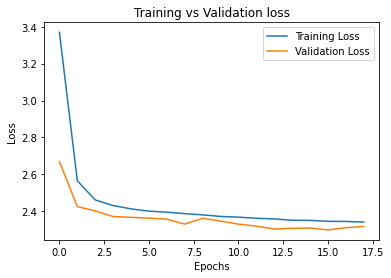

In [20]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

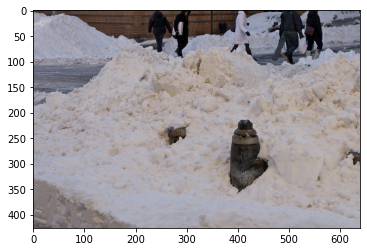

In [21]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
# hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
# references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

# print(f"Predicted caption: {hypo}")
# print("Original Captions:")
# for i in range(len(references)):
#     print(f"{i}. {references[i]}")

### The dreaded beam search

In [22]:
from beam_search import BeamSearch

In [23]:
type(img)

PIL.Image.Image

In [24]:
encoder.to(device)
# decoder.to(device)
encoder.eval()
# decoder.eval()

transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = transformer(img)
img = img.to(device)

features = encoder(img.unsqueeze(0)).unsqueeze(1)

In [26]:
beam = BeamSearch(decoder=decoder,
                  features=features,
                  word2idx=word2idx,
                  k=3, 
                  max_len=20)

sentence, score = beam.generate_caption()

tensor(0)
tensor([0])
<class 'torch.Tensor'>
tensor([[0., 0., 0.]], grad_fn=<CatBackward0>)
tensor([0., 0., 0.], grad_fn=<TopkBackward0>)
[(tensor([0, 0, 0]), tensor([0, 1, 2])), (tensor([0, 0, 0]), tensor([0, 1, 2])), (tensor([0, 0, 0]), tensor([0, 1, 2]))]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
decoder.embed(torch.Tensor(0))

In [ ]:
captions.shape

In [ ]:
captions.to(device)

In [20]:
decoder.embed(captions.to(device))

tensor([[[-1.7945e-04,  2.6349e-05, -2.7169e-02,  ..., -7.2708e-03,
          -2.3953e-03, -2.6244e-04],
         [ 2.0205e-04,  5.0817e-04,  7.4012e-03,  ..., -8.1961e-04,
           9.2585e-05, -9.7367e-04],
         [-1.2783e-05, -9.5791e-05,  3.9154e-03,  ...,  2.6534e-04,
          -7.4050e-05, -8.8375e-08],
         ...,
         [-1.6010e-04,  6.9283e-04,  1.1870e-02,  ...,  2.0286e-02,
           2.7279e-03, -9.3105e-04],
         [-5.3327e-05, -7.3673e-05, -2.1302e-04,  ..., -1.8845e-04,
          -1.8063e-04,  6.6030e-04],
         [ 1.7334e-42, -8.0294e-42, -1.2724e-42,  ...,  6.8902e-42,
          -7.3876e-42,  8.9585e-11]]], device='cuda:0',
       grad_fn=<EmbeddingBackward0>)

In [32]:
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 10k/2k/2k.\n'
print(MODEL_SUMMARY)

only images containing objects from sports super-category.
train/val/test size 10k/2k/2k.



In [60]:
import json

with open(Path('../model/summary_results')/'result_summary.json') as f:
    results = json.load(f)


for key, val in results.items():
    print('-------')
    print(key)
    print('-------')
    print(val['model_summary'])
    print('\n last validation losses')
    print([round(l,3) for l in val['val_loss'][-3:]])
    print('\n bleu scores:')
    print([round(b,3) for b in val['bleu_score']])

-------
sports_v2
-------
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 4
batch size: 128
embed size: 512

 last validation losses
[2.299, 2.311, 2.318]

 bleu scores:
[0.699, 0.517, 0.358, 0.248]
-------
sports_v4
-------
only images containing objects from sports super-category.
train/val/test size 15k/2k/2k
frequency threshold: 5
batch size: 64
embed size: 512
vocab build using entire train2017 captions data

 last validation losses
[2.425, 2.441, 2.445]

 bleu scores:
[0.665, 0.483, 0.335, 0.23]
-------
sports_v5
-------
only images containing objects from sports super-category.
train/val/test size 20k/3k/1k
frequency threshold: 5
batch size: 64
embed size: 1024

 last validation losses
[2.461, 2.38, 2.502]

 bleu scores:
[0.644, 0.462, 0.309, 0.212]
-------
everything
-------
images sampled from entire train2017 data set
train/val/test size 102k/15k/5k
frequency threshold: 5
batch size: 64
embed size: 512

 last valid

In [54]:
from nltk.translate import bleu_score

In [55]:
import os.path
from pathlib import Path
from typing import Union

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms

import json
import numpy as np
import time
import matplotlib.pyplot as plt

from PIL import Image
from nltk.translate import bleu_score